# SBI experiments: the Two Moons toy model

In [1]:
import sys

sys.path.append("..")

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import simulate_for_sbi, SNPE, SNLE, SRE
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from sbisandbox.examples.twomoons import TwoMoonsToyModel
from sbisandbox.pipeline import InferencePipeline

%config InlineBackend.figure_format = 'retina'
sns.set_theme()

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
two_moons = TwoMoonsToyModel()

In [3]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(two_moons.prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(two_moons.simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

Plotting:

Running 10000 simulations.: 100%|██████████| 10000/10000 [00:01<00:00, 6631.41it/s]


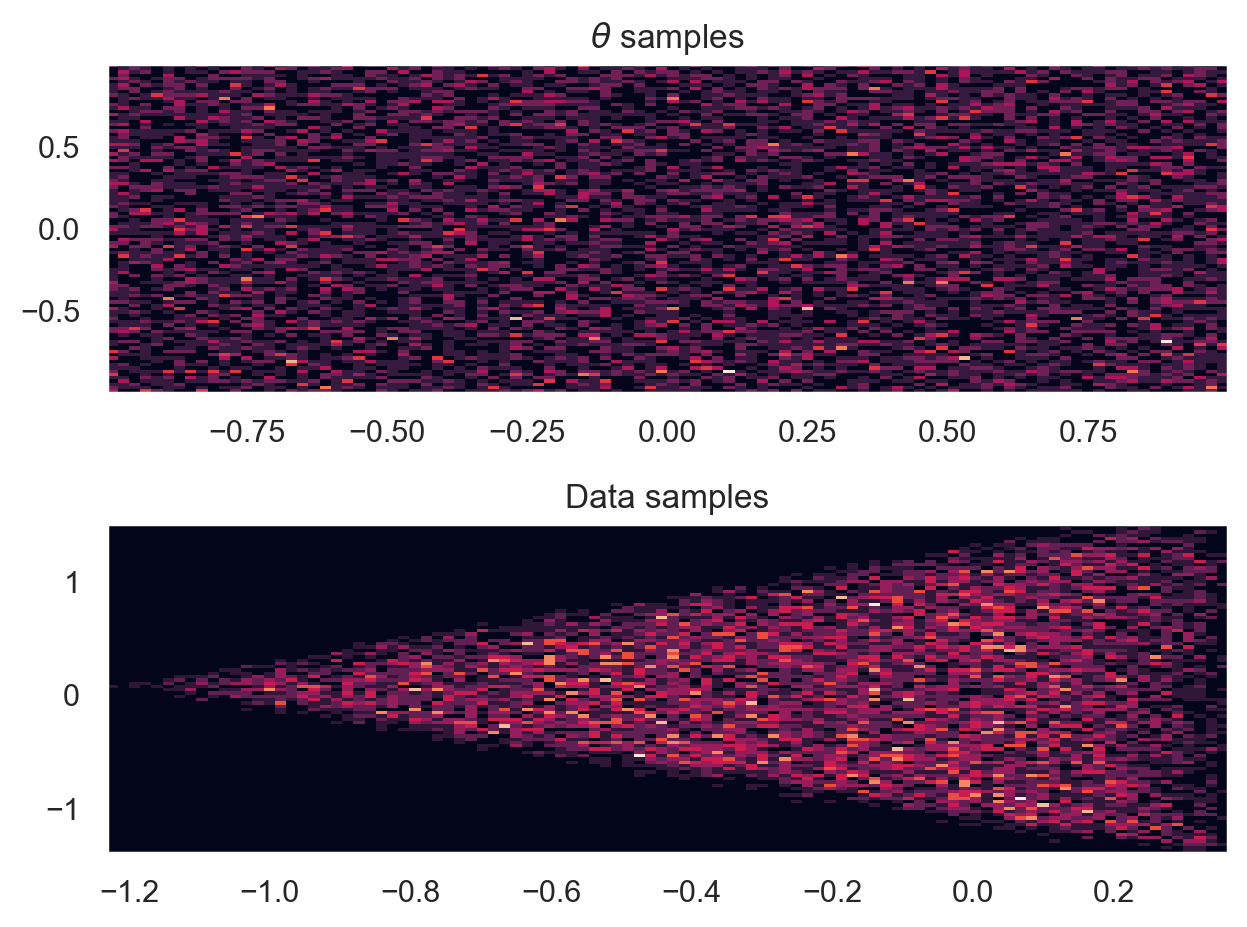

In [4]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist2d(theta[:, 0], theta[:, 1], bins=100)
ax2.hist2d(x[:, 0], x[:, 1], bins=100)
ax1.set_title(r"$\theta$ samples")
ax2.set_title(r"Data samples")
fig.tight_layout()
plt.show()

<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>

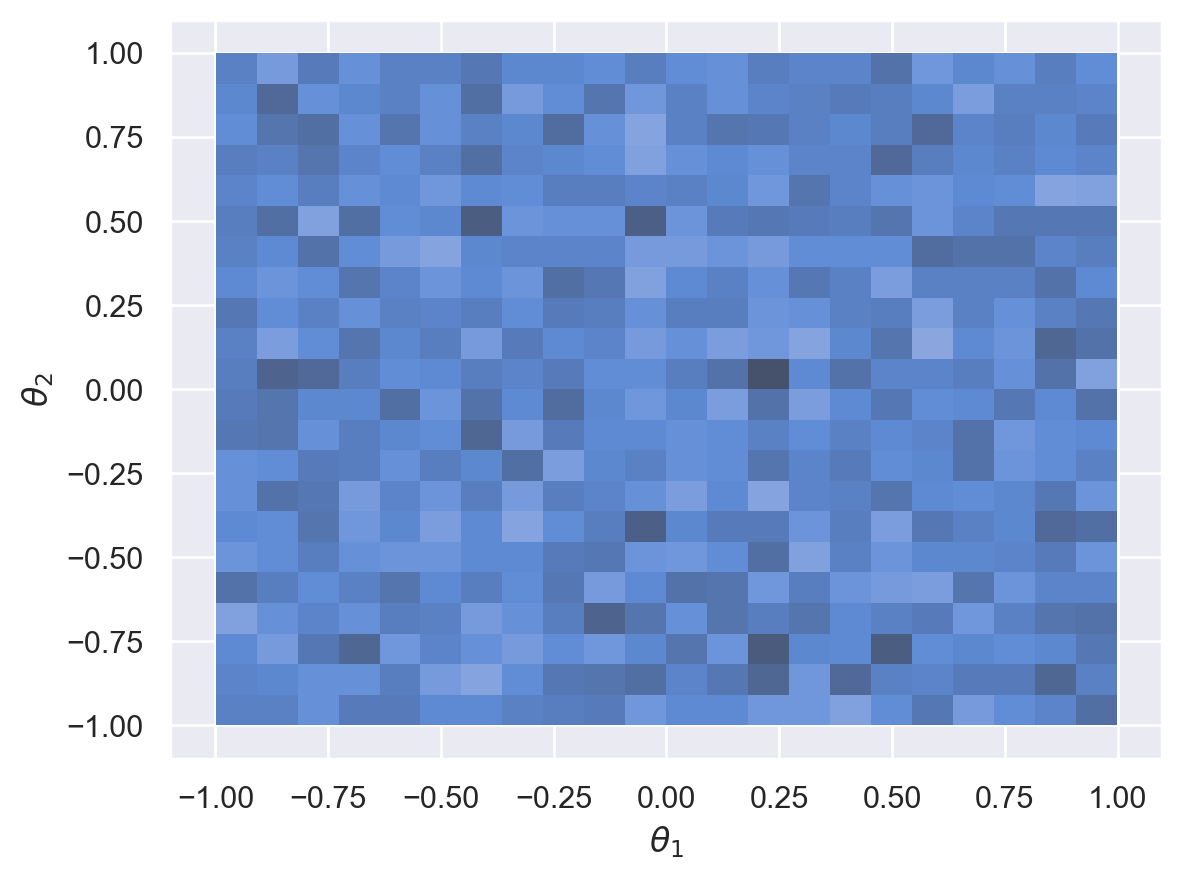

In [5]:
labels = ["$\\theta_1$", "$\\theta_2$"]
data = dict(zip(labels, (theta[:, 0], theta[:, 1])))
sns.histplot(data=data, x=labels[0], y=labels[1])

<Axes: xlabel='$x_1$', ylabel='$x_2$'>

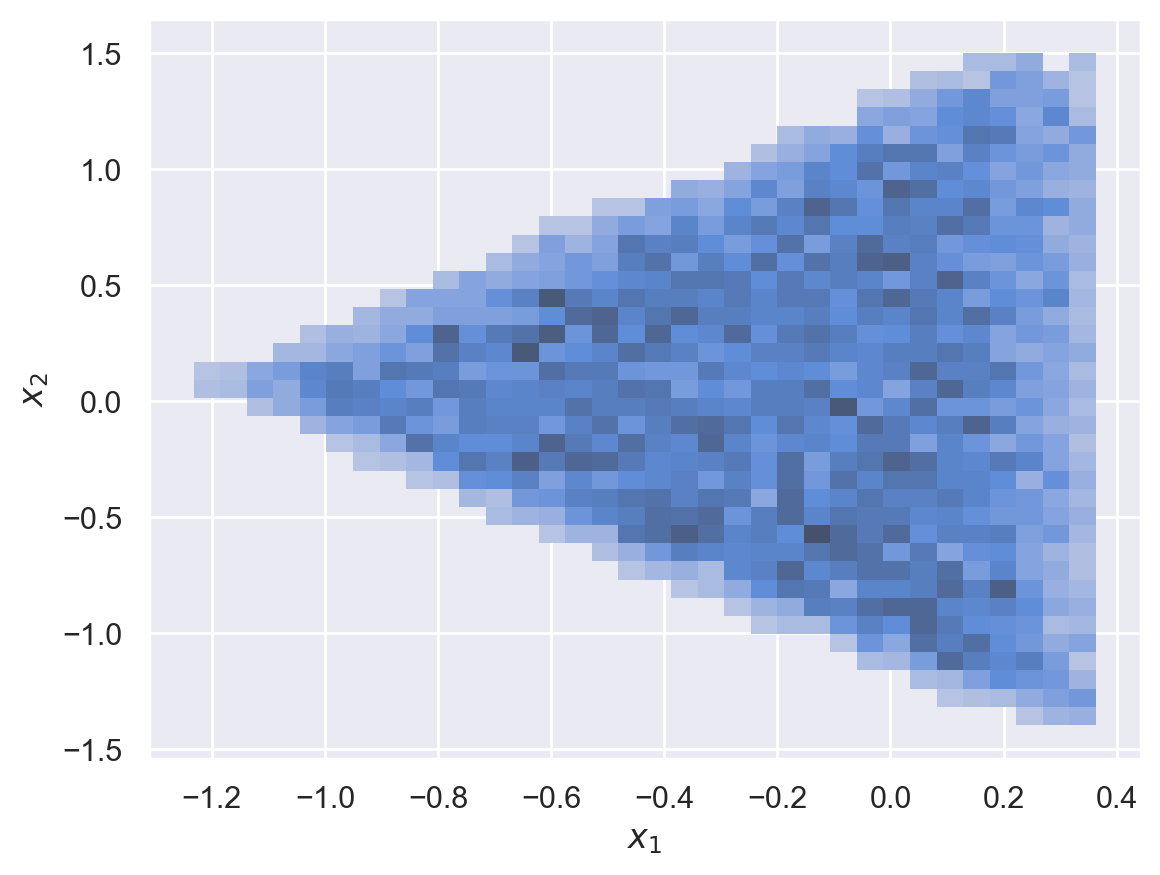

In [6]:
labels = ["$x_1$", "$x_2$"]
data = dict(zip(labels, (x[:, 0], x[:, 1])))
sns.histplot(data=data, x=labels[0], y=labels[1])

In [7]:
algorithms = [SNPE(prior=prior), SNLE(prior=prior), SRE(prior=prior)]
pipeline = InferencePipeline(algorithms)
pipeline.append_simulations(theta, x)

In [9]:
pipeline.train(num_workers=None)

 Neural network successfully converged after 71 epochs..

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 16184.34it/s]


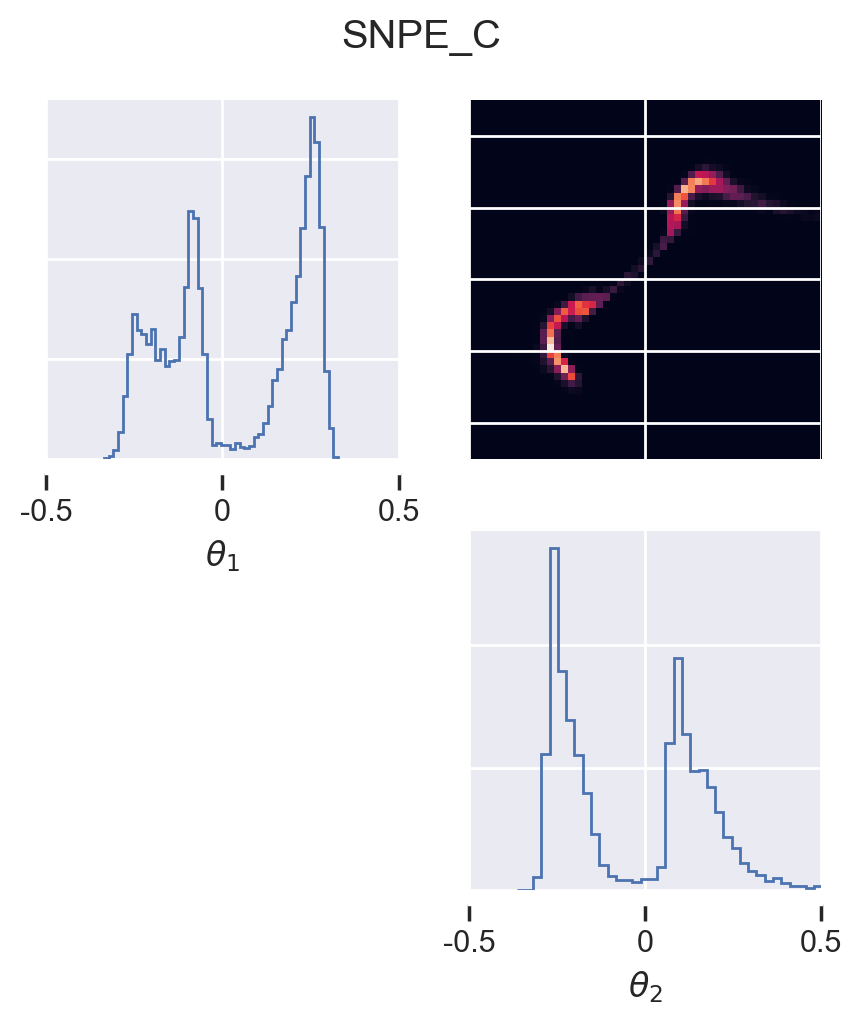

Generating samples:   1%|          | 1004/100100 [04:59<8:12:22,  3.35it/s] 


KeyboardInterrupt: 

In [11]:
x_0 = torch.zeros(2)
for posterior, algo in zip(pipeline.build_posterior(), algorithms):
    posterior_samples = posterior.sample((10000,), x=x_0)

    # plot posterior samples
    fig, axs = analysis.pairplot(
        posterior_samples,
        limits=[[-0.5, 0.5], [-0.5, 0.5]],
        labels=["$\\theta_1$", "$\\theta_2$"],
        figsize=(5, 5),
    )
    fig.suptitle(type(algo).__name__)
    plt.show()